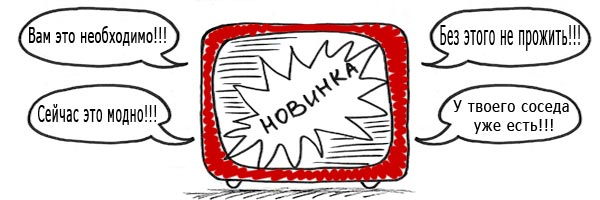

# <center> Исследование зависимости продаж от рекламы

### Задача

Необходимо построить прогностическую модель для продаж некоторого продукта на основе количества денег, потраченных на рекламу.

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
# Импортируем графический инструментарий
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка и подготовка данных

In [2]:
# Загрузим и взглянем на датасет
df = pd.read_csv('Advertising.zip', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Как видим, датасет у нас довольно простой: все признаки числовые, количество наблюдений всего 200 - вполне годится для скромных попыток исследовать собственные способности писать код для оптимизации некоторых известных функций.

In [3]:
# Исследвуем датасет на наличие пропусков
df.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Пропусков нет.

Преобразуем наши признаки в массивы NumPy и разделим их на переменные `X` (предикторы) и `y` (целевая переменная). 

In [4]:
X = df[['TV', 'radio', 'newspaper']].values
y = df['sales'].values

## Классический градиентный спуск

Добавим в `X` столбец единиц (для будущей константы), и преобразуем наши массивы для адльнейших матричных операций.

In [5]:
n = len(y)
X_gd = np.append(np.ones((n, 1)), X.reshape(n, 3), axis=1)
y_gd = y.reshape(n, 1)

# Инициализируем вектор параметров
par = np.zeros((4,1))

Напишем функции для расчета потерь и непосредственной реализации метода градиентного спуска.

In [6]:
def cost_function(X: np.array, y: np.array, par: np.array) -> np.array:
    '''
    Функция для расчета потерь.
    Args:
        X (np.array): матрица признаков;
        y (np.array): вектор целевого признака;
        par (np.array): вектор параметров.
    Returns:
        np.array: значение функции потерь.
    '''
    
    y_pred = np.dot(X, par)
    error = (y_pred - y)**2
    cost = 1/(n)*np.sum(error)
    
    return cost

def grad_d(X: np.array, y: np.array, par: np.array, alpha: float, iterations: int) -> tuple:
    '''
    Функция для реализации метода градиентного спуска.
    Args:
        X (np.array): матрица признаков;
        y (np.array): вектор целевого признака;
        par (np.array): вектор параметров;
        alpha (float): скорость обучения;
        iterations (int): число итераций.
    Returns:
        np.array: вектор рассчитанных параметров;
        list: список значений функции потерь.
    '''
    
    costs = []
    for i in range(iterations):
        y_pred = np.dot(X, par)
        der = np.dot (X.transpose(), (y_pred - y))/ n
        par -= alpha * der
        costs.append(cost_function(X, y, par))
    
    return par, costs

Протестируем наши алгоритмы на всем объеме датасета.

In [7]:
par, costs = grad_d(X_gd, y_gd, par, 0.00005, 500000)

print('Вектор весов, к которому сошелся метод GD:')

for w in par:
    print(round(*w, 5), end=' ')

gd_mse = round(costs[-1], 5)
print('\n','Final cost: ', gd_mse, sep='')

Вектор весов, к которому сошелся метод GD:
2.86255 0.04597 0.18941 -0.00057 
Final cost: 2.78498


Проверим наши расчеты библиотечными функциями.

In [8]:
mod = sm.OLS(y_gd, X_gd)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.58e-96
Time:                        16:12:02   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

Веса прекрасно сошлись, а теперь sklearn.

In [9]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_gd, y_gd)
print('Вектор весов:')

for w in lr.coef_[0]:
    print(round(w, 5), end=' ')

y_pred_lr = lr.predict(X_gd)
lr_mse = round(metrics.mean_squared_error(y, y_pred_lr), 5)
print('\n', 'Final cost: ', lr_mse, sep='')

Вектор весов:
2.93889 0.04576 0.18853 -0.00104 
Final cost: 2.78413


Чудесно, мы успешно создали свой собственный код градиентного спуска - и он даже работает!

## Координатный спуск

Метод координатного спуска можно считать одним из простейших методов оптимизации , который в целом достаточно эффективно ищет локальные минимумы для гладких функций. При поиске минимума с помощью этого метода мы всегда изменяем положение точки в направлении осей координат, т. е. всегда изменяется только одна координата, и благодаря этому задача становится одномерной.

По сути, мы просто выбираем некоторую точку и правило изменения координаты и движемся в соответствии с ним до локального минимума.

Нормализуем данные: обычно это необходимо для корректной работы алгоритма.

In [10]:
X_norm = X_gd / np.sqrt(np.sum(np.square(X_gd), axis=0))

#### Реализуем алгоритм координатного спуска

Алгоритм координатного спуска для случая нормализованных данных следующий:

**Задано:**

* $X=(x_{ij})$ - матрица наблюдений, размерностью $dim(X)=(n, m)$
* $N=1000$ - количество итераций

**Примечание:** *Число итераций здесь указано для нашей задачи, на самом деле оно может быть намного больше, нет детерменированного значения.*

**Алгоритм (математическая запись):**
* Создать нулевой вектор параметров $w_0=(0, 0,..., 0)^T$
* Для всех $t=1, 2, ..., N$ итераций:
    * Для всех $k = 1, 2,..., m$:
        * Фиксируем значение всех признаков, кроме $k$-ого и вычисляем прогноз модели линейной регрессии.Для этого исключаем признак $k$-ый из данных и $w_j$ из параметров при построении прогноза.
        Математически это можно записать следующим образом:

        $$h_i = \sum_{j=1}^{k-1} x_{ij}w_{j} + \sum_{j=k+1}^{m} x_{ij}w_j $$

         **Примечание:**
         *В данной записи текущий признак под номером $k$ не участвует в сумме. Сравним эту запись с классической записью прогноза линейной регрессии в случае нормированных данных (когда участвуют все признаки):*

        $$h_i = \sum_{j=1}^{m} x_{ij}w_{j}$$ 
        
        * Вычисляем новое значение параметра $k$-ого коэффициента: 
        $$w_k = \sum_{i=1}^{n} x_{ik} (y_i - h_i) = x_k^T(y-h) $$

    * Вычисляем значение функции потерь и сохраняем в историю изменения функции потерь (В оценке функции потерь участвуют все признаки):
        $$\hat{y_i} = \sum_{j=1}^{m}x_{ij}w_j$$
        $$Loss_t = \frac{1}{n} \sum_{i=1}^{n}(y_i-\hat{y_i})^2$$
        
        или в векторном виде:
        
        $$\hat{y} = Xw$$
        $$Loss_t = \frac{1}{n}(y-\hat{y})^T(y-\hat{y})$$


Теперь мы готовы реализовать координатный спуск, и вывести веса модели линейной регрессии.

In [11]:
# Напишем функцию координатного спуска
def CDf(X: np.array, y: np.array, num_iters=1000) -> np.array:
    """
    Функция реализующая координатный спуск. 
    Args:
        X (np.array): матрица признаков;
        y (np.array): вектор целевого признака;
        num_iters (int, default=1000): число итераций.

    Returns:
        np.array: вектор-массив итоговых весов алгоритма.
    """
    
    # Количество строк и столбцов в матрице X
    m, n = X.shape
    # Нулевой вектор размера nx1 (будущий вектор весов)
    w = np.zeros(n).reshape(-1, 1)
    
    for i in range(num_iters):
        for k in range(n):
            # Вычисляем прогноз без k-ого фактора
            h = (X[:,0:k] @ w[0:k]) + (X[:,k+1:] @ w[k+1:])
            # Обновляем новое значение k-ого коэффициента
            w[k] =  (X[:,k].T @ (y - h))
            # Вычисляем функцию потерь
            cost = sum(((X @ w) - y) ** 2)/(len(y))
            
    # Возвращаем получившийся вектор весов
    return w.T

# Воспользуемся нашей функцией и выведем результат
print(CDf(X_norm, y_gd))

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


Сравним результаты с реализацией линейной регрессии из библиотеки sklearn:

In [12]:
lr_cd = LinearRegression(fit_intercept=False)
lr_cd.fit(X_norm, y)

print(lr_cd.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Они практически совпали!

## Стохастический градиентный спуск

Отмасштабируем столбцы исходной матрицы `X` (которую мы не нормализовали). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение.

In [13]:
X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Добавим единичный столбец.

In [14]:
X_sgd = np.hstack([np.ones(X_scaled.shape[0]).reshape(-1, 1), X_scaled])

Создадим функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse. Ранее мы уже написали функцию cost_function для аналогичных целей, но теперь мы хотели бы уменьшить число действий ею совершаемых - число переменных сократится также: здесь мы работаем только предсказанием некоего алгоритма.

In [15]:
def mse_error(y: np.array, y_pred: np.array) -> float:
    """
    Функция расчета среднеквадратичной ошибки.
    Args:
        y (np.array): вектор целевого признака;
        y_pred (np.array): вектор предсказанных значений.
    Returns:
        float: значение метрики MSE.
    """
    
    mse = np.mean(np.square(y-y_pred))
    
    return mse

Сделаем наивный прогноз: предскажем продажи средним значением. После этого рассчитаем среднеквадратичную ошибку для этого прогноза.

In [16]:
mean_sale = np.mean(y) # Средняя продажа
y_pred = np.full_like(y, mean_sale) # Массив "предсказания"
print(f'Размер средней продажи {mean_sale}')
print(f'MSE: {round(mse_error(y, y_pred), 4)}')

Размер средней продажи 14.0225
MSE: 27.0857


Создадим функцию `lin_pred`, которая может по матрице предикторов `X` и вектору весов линейной модели `w` получить вектор прогнозов.

In [17]:
def lin_pred(X: np.array, w: np.array) -> np.array:
    """
    Функция расчета среднеквадратичной ошибки.
    Args:
        X (np.array): матрица предикторов;
        w (np.array): вектор весов.
    Returns:
        np.array: вектор прогнозов.    
    """
    
    y_pred = X @ w
    
    return y_pred

Создадим функцию `stoch_grad_step` для реализации шага стохастического градиентного спуска.<br>
Функция будет принимать на вход следующие аргументы:
* матрицу `X`
* вектора `y` и `w`
* число `train_ind` - индекс объекта обучающей выборки (строки матрицы `X`), по которому считается изменение весов
* число $\eta$ (eta) - шаг градиентного спуска

Результат - вектор обновленных весов.

Шаг для стохастического градиентного спуска в математических выражениях выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Мы знаем, что для того, чтобы написать функцию, нужно сделать следующее:
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным;
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска.

In [18]:
def stoch_grad_step(X: np.array, y: np.array, w: np.array, train_ind: int, eta: float) -> np.array:
    """
    Функция реализующая шаг стохастического градиентного спуска.
    Args:
        X (np.array): матрица предикторов;
        y (np.array): вектор целевого признака;
        w (np.array): вектор весов;
        train_ind (int): индекс объекта обучающей выборки;
        eta (float): скорость обучения.
    Returns:
        np.array: вектор обновленных весов.
    """
    
    weights = []
    
    for j in range(X.shape[1]):
        y_pred = np.dot(w[j], X[train_ind, j])
        weight = 2 * eta * (X[train_ind, j] * (y_pred-y[train_ind]))
        weights.append(weight)
    w_new = (w - np.array(weights))[:, 0].reshape(-1, 1)
    
    return w_new

Создадим функцию `stochastic_gradient_descent`, для реализации стохастического градиентного спуска.

Функция будет принимать на вход следующие аргументы:
- матрицу признаков X;
- целевую переменнную;
- изначальную точку (веса модели);
- параметр, определяющий темп обучения;
- максимальное число итераций;
- евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу.

На каждой итерации в вектор (список) будет записываться текущее значение среднеквадратичной ошибки. Функция возвращает вектор весов $w$, а также вектор (список) ошибок.

Алгоритм функции:
* Инициализация расстояния между векторами весов на соседних итерациях большим числом (можно бесконечностью).
* Создание пустого списка для фиксации ошибок.
* Создание счетчика итераций.
* Реализация оновного цикла обучения, пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: генерация случайного индекса, запись текущей ошибки в вектор ошибок, запись в переменную текущего шага стохастического спуска с использованием функции, написанной ранее. Далее - рассчет текущего расстояния между векторами весов и приращение счетчика итераций на 1.
* Возвращаются - вектор весов и список ошибок.

In [19]:
def stochastic_gradient_descent(X, y, w, eta, max_iter, e_dist):
    """
    Функция реализующая стохастический градиентный спуск.
    Args:
        X (np.array): матрица признаков;
        y (np.array): вектор целевой переменной;
        w (np.array): вектор инициализирующих весов;
        eta (float): темп обучения;
        max_iter (int): предельное число итераций;
        e_dist (float): предельное расстояние между последней парой векторов весов.
    Returns:
        np.array: массив итоговых весов;
        list: список значений MSE.
    """
    
    # Инициализация начального расстояния между векторами весов
    dist = np.inf
    # Список фиксации ошибок и счетчик итераций
    errors, itr_cntr = [np.inf], 0
    # Вектор лучших весов
    w_best = w
    
    # Реализуем цикл обучения
    while dist > e_dist and itr_cntr < max_iter:
        # Сохраняем исходный вектор весов
        prev_w = w
        # Случайно избираем объект обучающей выборки
        train_ind = np.random.randint(X.shape[0])
        # Реализуем шаг стохастического градиентного спуска
        w = stoch_grad_step(X, y, w, train_ind, eta)
        # Считаем ошибку
        error = mse_error(y, lin_pred(X, w))
        # Если ошибка является наименьшей
        if error < min(errors):
            # Перезаписываем вектор наилучших весов
            w_best = w
            # Сохраняем значение MSE для данной итерации
            errors.append(error)
        # Обновляем расстояние между векторами
        dist = np.linalg.norm(prev_w - w)
        # Фиксируем итерацию в счетчике
        itr_cntr += 1
    
    # Выводим кортеж итогового массива весов и списка значений MSE
    return w_best, errors

Запустим $10^5$ итераций стохастического градиентного спуска. Укажем вектор начальных весов, состоящий из нулей. Построим график зависимости ошибки от номера итерации.

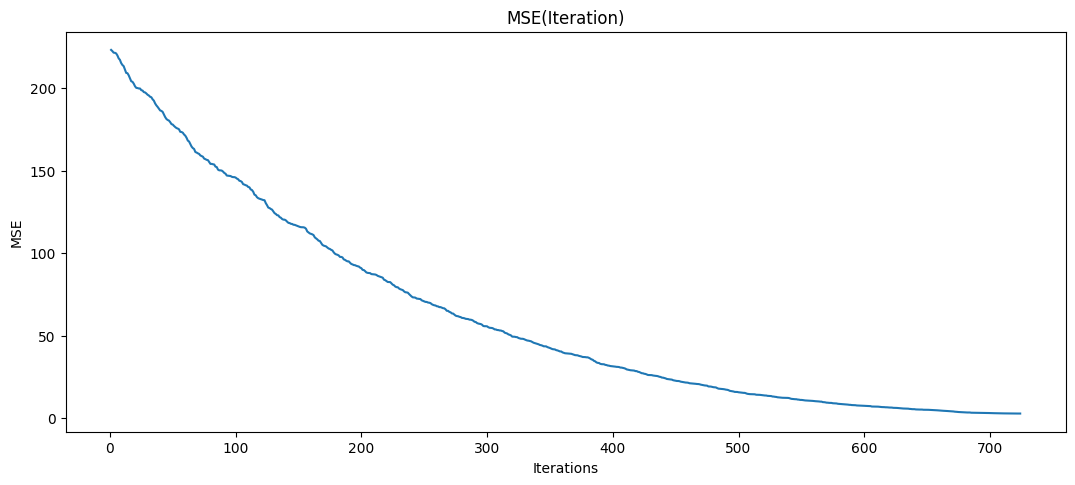

In [20]:
# Получаем вектор весов и коллекцию поитеративно рассчитанных значений MSE
weights, errors = stochastic_gradient_descent(X_sgd, y_gd, np.array([0,0,0,0]), 0.001, 1e5, 1e-7)
# Строим графику
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(range(len(errors)), errors)
axes.set_title('MSE(Iteration)')
axes.set_xlabel('Iterations')
axes.set_ylabel('MSE');

Можем наблюдать пологий спуск: мы сохраняли лишь те ошибки, что были меньше предыдущих.

In [21]:
print('Вектор весов, к которому сошелся метод:')

for w in weights:
    print(round(*w, 5), end=' ')

sgd_mse = round(errors[-1], 5)
print('\n', 'Final MSE: ', sgd_mse, sep='')

Вектор весов, к которому сошелся метод:
13.97307 3.88637 2.80897 -0.02441 
Final MSE: 2.78786


Сравним нашу скромную поделку с библиотечным слоном.

In [22]:
model_SGD = SGDRegressor(fit_intercept=False, max_iter=int(1e5))
model_SGD.fit(X_sgd, y)

print('Вектор весов, к которому сошлась библиотечная модель SGDRegressor:')
for w in model_SGD.coef_:
    print(round(w, 5), end=' ')
    
y_pred_sgd = model_SGD.predict(X_sgd)
sgdr_mse = round(metrics.mean_squared_error(y, y_pred_sgd), 5)
print('\n', 'MSE: ', sgdr_mse, sep='')

Вектор весов, к которому сошлась библиотечная модель SGDRegressor:
14.01209 3.91405 2.77954 -0.00663 
MSE: 2.78453


Веса уже несколько другие, да значение метрики заметно лучше: разница, разумеется, в глубине настройки параметров.

Сравним с нашим же координатным спуском.

In [23]:
w_norm = CDf(X_norm, y_gd)[0].reshape(-1, 1)
print('Вектор весов, к которому ранее сошелся метод CD:')

for w in w_norm:
    print(round(*w, 5), end=' ')

cd_mse = round(mse_error(y_gd, lin_pred(X_norm, w_norm)), 5)
print('\n', 'Final CDs MSE: ', cd_mse, sep='')

Вектор весов, к которому ранее сошелся метод CD:
41.56217 110.13144 73.52861 -0.55006 
Final CDs MSE: 2.78413


Здесь же нам удалось даже немного превзойти библиотечный аналог.

## Результаты

In [24]:
results_df = pd.DataFrame(
    data=[[gd_mse, lr_mse, sgd_mse, sgdr_mse, cd_mse]],
    columns=[
        'Gradient Descent', 'Linear Regression',
        'Stochastic Gradient Descent',
        'SGDRegressor', 'Coordinate Descent'
    ],
    index=['MSE']
)

results_df

,Gradient Descent,Linear Regression,Stochastic Gradient Descent,SGDRegressor,Coordinate Descent
MSE,2.78498,2.78413,2.78786,2.78453,2.78413


Для данной задачи все наши модели показали себя примерно одинаково - с разницей от нескольких десятитысячных до тысячных среднеквадратической ошибки. Наша модель стохастического градиентного спуска оказалась менее стабильной, чем все другие, т.к. при реализации стохастического спуска вычисляются градиенты не для всей выборки, а только для случайно выбранной единственной точки, поэтому от итерации к итерации итоговое значение метрики может несколько колебаться. Надо полагать, библиотечный *SGDRegressor* реализован немного по-другому и более интереснее :)